In [9]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm, trange
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification

from segment.utils import loadModel, segment
from triplet import TripletImageFolder

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def mask_inputs(image):
    rl_mask, ll_mask, h_mask = segment(image / 255., segmodel, device=DEVICE)
    return (image * (rl_mask | ll_mask | h_mask).astype(int) / 255.).astype(np.float32)

In [3]:
segmodel = loadModel("models/weights.pt", torch.device("cuda"))

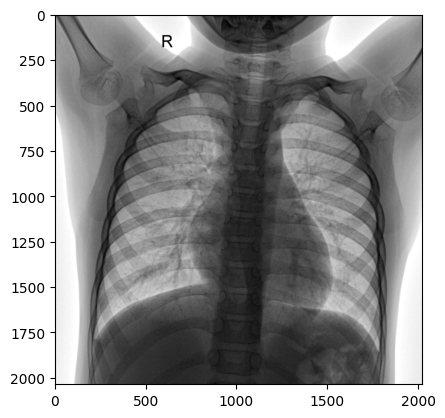

In [4]:
image = cv2.imread("sample.jpeg", 0)
plt.imshow(image, "binary");

C:\Users\Wei Min\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


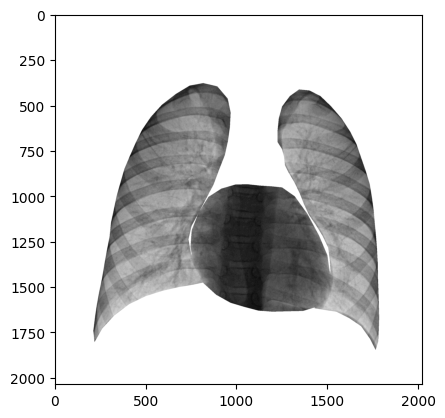

In [5]:
plt.imshow(mask_inputs(image), "binary");

In [6]:
dataset = ImageFolder("data/train", transform=transforms.Compose([transforms.Grayscale(),
                                                                  np.asarray,
                                                                  mask_inputs,
                                                                  transforms.ToPILImage(),
                                                                  transforms.Grayscale(3),
                                                                  transforms.Resize((112, 112)),
                                                                  transforms.ToTensor()]))
dl = DataLoader(dataset, batch_size=4, shuffle=True)

dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

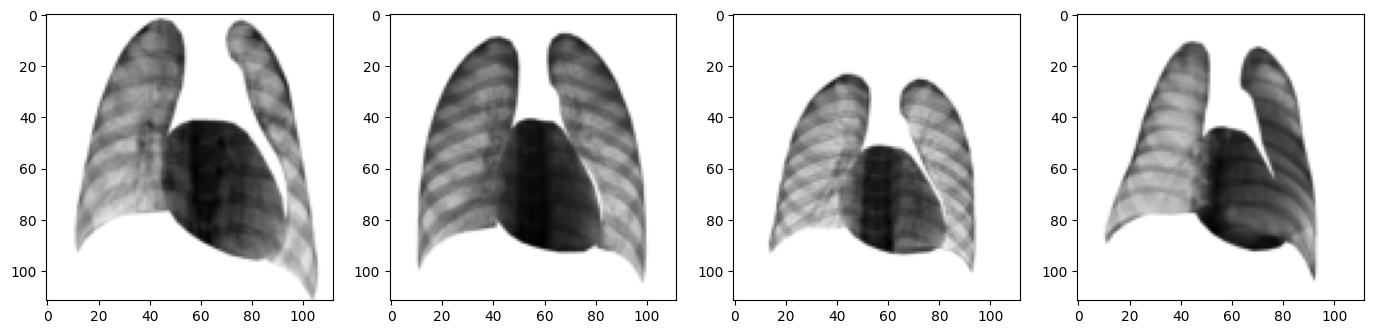

In [7]:
_, axs = plt.subplots(1, 4, figsize=(17, 5))
image_batch = next(iter(dl))[0]
for i in range(4):
    axs[i].imshow(image_batch[i][0] / 255., "binary")

In [15]:
# https://huggingface.co/microsoft/dit-large-finetuned-rvlcdip
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    processor = AutoImageProcessor.from_pretrained("microsoft/dit-large-finetuned-rvlcdip")
    model = AutoModelForImageClassification.from_pretrained("microsoft/dit-large-finetuned-rvlcdip")

model.classifier = nn.Linear(1024, 2)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [18]:
triplet_ds = TripletImageFolder(root="data/train", transform=transforms.Compose([transforms.Grayscale(),
                                                                                 np.asarray,
                                                                                 mask_inputs,
                                                                                 transforms.ToPILImage(),
                                                                                 transforms.Grayscale(3),
                                                                                 transforms.Resize((112, 112)),
                                                                                 transforms.ToTensor()]))
triplet_dl = DataLoader(triplet_ds, batch_size=4, shuffle=True)

In [ ]:
image_batch = np.asarray((next(iter(dl))[0] / 255.), dtype=np.uint8)
inputs = processor(images=image_batch, return_tensors="pt")
outputs = model(**inputs)
print(outputs.logits.shape)

In [19]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.TripletMarginLoss()

In [28]:
model.train()
model.to(DEVICE)

for e in range(1):
    for i, (anc, pos, neg) in enumerate(tqdm(triplet_dl, total=len(triplet_dl))):
        anc = anc.to(DEVICE)
        pos = pos.to(DEVICE)
        neg = neg.to(DEVICE)
        loss = loss_fn(model(anc).logits, model(pos).logits, model(neg).logits)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 50:
            break

model.eval()
model.cpu();

  4%|▍         | 51/1308 [00:35<14:40,  1.43it/s]


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): BeitIntermediate(
            (dense): Linear(

In [29]:
anc, pos, neg = next(iter(triplet_dl))
with torch.no_grad():
    anc_emb = model(anc).logits
    pos_emb = model(pos).logits
    neg_emb = model(neg).logits

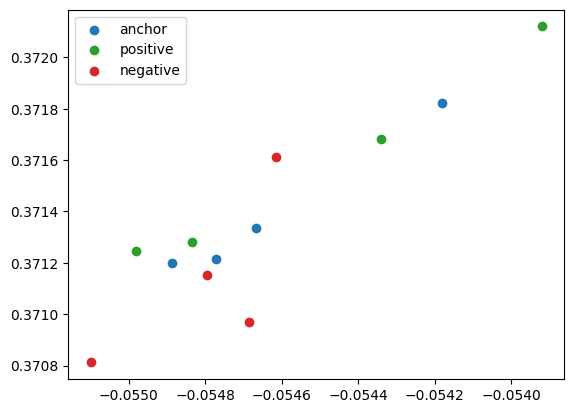

In [31]:
plt.scatter(*anc_emb.numpy().T, label="anchor", c="tab:blue")
plt.scatter(*pos_emb.numpy().T, label="positive", c="tab:green")
plt.scatter(*neg_emb.numpy().T, label="negative", c="tab:red")
plt.legend();